In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle


# SimPEG imports
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh


# SBI imports
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis


## Schlumberger Array 
Experiment Setup of the 1D DC resistivity measurements of the layered Earth model. 
Define Schlumberger Array according to min_distance, max_distance, the spacing and the number of measurements. 



In [2]:
def schlumberger_survey(num_measurements, min_ab_distance, max_ab_distance, spacing='log'):
    # Define the 'a' spacing for Schlumberger array measurements for each reading 
    if spacing == 'log': 
        a_b_electrode_separations = np.logspace(np.log10(min_ab_distance), np.log10(max_ab_distance), num_measurements)
        m_n_electrode_separations = 0.01 * a_b_electrode_separations 
    elif spacing == 'lin': 
        a_b_electrode_separations = np.linspace(min_ab_distance, max_ab_distance, num_measurements)
        m_n_electrode_separations = 0.01 * a_b_electrode_separations 
    else:
        raise Exception('Invalid Spacing - needs to be a string of either "log" or "lin" but it was given', spacing)
        
    
    source_list_log = []  # create empty array for sources to live
    
    for ab, mn in zip(a_b_electrode_separations, m_n_electrode_separations):
    
    
        # AB electrode locations for source. Each is a (1, 3) numpy array
        A_location = np.r_[-ab, 0.0, 0.0]
        B_location = np.r_[ab, 0.0, 0.0]
    
        # MN electrode locations for receivers. Each is an (N, 3) numpy array
        M_location = np.r_[-mn, 0.0, 0.0]
        N_location = np.r_[mn, 0.0, 0.0]
    
        # Create receivers list. Define as pole or dipole.
        receiver_list = dc.receivers.Dipole(
            M_location, N_location, data_type="apparent_resistivity"
        )
        receiver_list = [receiver_list]
    
        # Define the source properties and associated receivers
        source_list_log.append(dc.sources.Dipole(receiver_list, A_location, B_location))
    
    # Define survey
    survey = dc.Survey(source_list_log)
    
    electrode_separations = 0.5 * np.sqrt(
        np.sum((survey.locations_a - survey.locations_b) ** 2, axis=1)
        
    )
    return survey, electrode_separations

## Forward model wrapper

According to the survey setup from above we have the electrode spacing. Now we define a wrapper for the actual forward model such that it receives the thicknesses and the respective resistivities of the individual layers of th e

In [3]:
# Note parameters are composed of resistivities and thicknesses - in that order. First resistivities then thicknesses
def dc_forward_model(resistivities, thicknesses, survey):
        
    # Define mapping from model to 1D layers.
    model_map = maps.IdentityMap(nP=len(resistivities))
    # SimPegs 1D Simulation 
    simulation = dc.simulation_1d.Simulation1DLayers(
        survey=survey,
        rhoMap=model_map,
        thicknesses=thicknesses,
    )
    
    # Predict data for a given model
    pred = simulation.dpred(resistivities)
    return pred

In [4]:
def dc_forward_model_for_sbi (params, survey):
    # Split params into resistivities and thicknesses
    param_length = len(params)
    number_of_layers = int((param_length+1)/2)
    # First half of parameters is resistivities
    resistivities = params[:number_of_layers]
    # Second half of parameters are thicknesses
    thicknesses = params[number_of_layers:]
        
    return dc_forward_model(resistivities, thicknesses, survey)

## Forward Simulation - Textbook example
The Textbook referred to is "Resistivity and Induced Polarization Theory and Applications to the Near-Surface Earth" 
The example referred to is the one in Chapter 4, Figure 4.9 
In this example we have a three layered earth model with the following resistivity values [500$\Omega m$, 200$\Omega m$, 500$\Omega m$ / 50$\Omega m$].
In this model we assume an infinite base layer and the thickness of the first two layers are 5m for the first layer, 10m for the second layer 

In [5]:
num_measurements = 20
min_spacing = 1
max_spacing = 1000
earth_resistivities = [500,200,50]
earth_layer_thicknesses = [5,10,]


textbook_survey, textbook_electrode_spacing = schlumberger_survey(num_measurements, min_spacing, max_spacing)
apparent_resistivities_textbook = dc_forward_model(earth_resistivities, earth_layer_thicknesses, textbook_survey)

## SBI Inversion - Textbook example

In the following section we try to infer the earth_resistivities and earth_layer_thicknesses and assume we only measured the apparent resistivities ( the same ones we just now simulated by the forward model)

In [6]:
def dc_forward_model_for_sbi_fixed_resistivities(resistivities):
    return dc_forward_model(resistivities, earth_layer_thicknesses, textbook_survey)
    

In [7]:
def sbi_wrapper(simulator, prior, num_simulations): 
    # Initialise an SNPE inference object
    inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)
    # Simulate the forward model num_simulations many times from the wrapped forward model an
    theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_simulations)    
    # Pass the simulated data in pairs of parameters theta and simulated data x to the inference object
    inference = inference.append_simulations(theta, x)
    # Train the inference object
    density_estimator = inference.train()
    # Build posterior from the inference object
    posterior = inference.build_posterior(density_estimator)

    return posterior, theta, x
    

### 1. Standard SNPE approach with 1000 simulations 

In [8]:
num_dim = 3
prior_min = torch.as_tensor([0,0,0])
prior_max = torch.as_tensor([5000,5000,5000])

# Define the prior as a BoxUniform distribution
prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))
# Define the prior and the simulator for sampling based on the wrapped forward model and the prior

simulator, prior = prepare_for_sbi(dc_forward_model_for_sbi_fixed_resistivities, prior)

In [9]:
posterior, theta, x = sbi_wrapper(simulator, prior, 1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 167 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

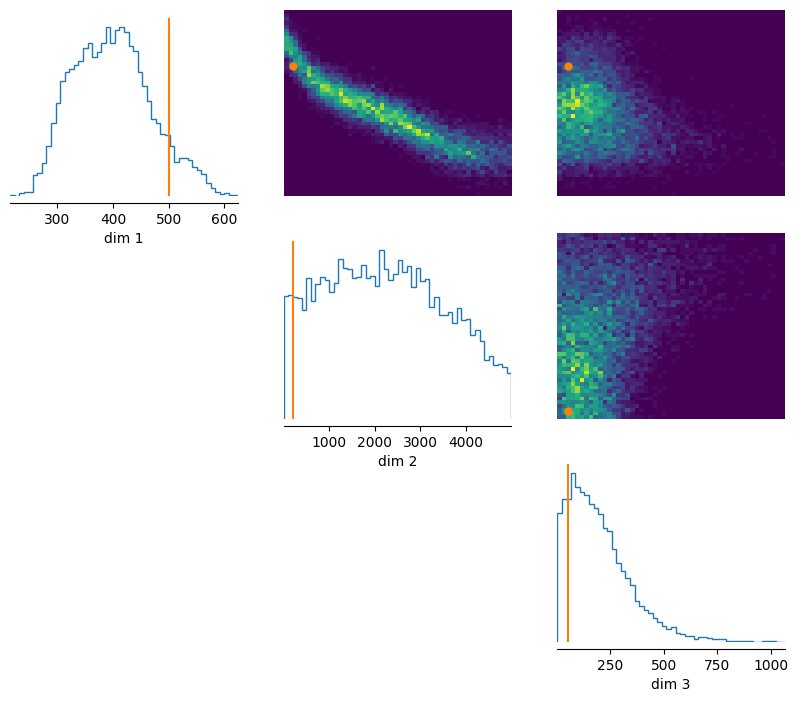

In [12]:
# Sample from the posterior distribution
posterior_samples = posterior.sample((10000,), x=apparent_resistivities_textbook)
# plot Posterior samples
_ = analysis.pairplot(posterior_samples,points= torch.tensor([500,200, 50]), figsize=(10,8))

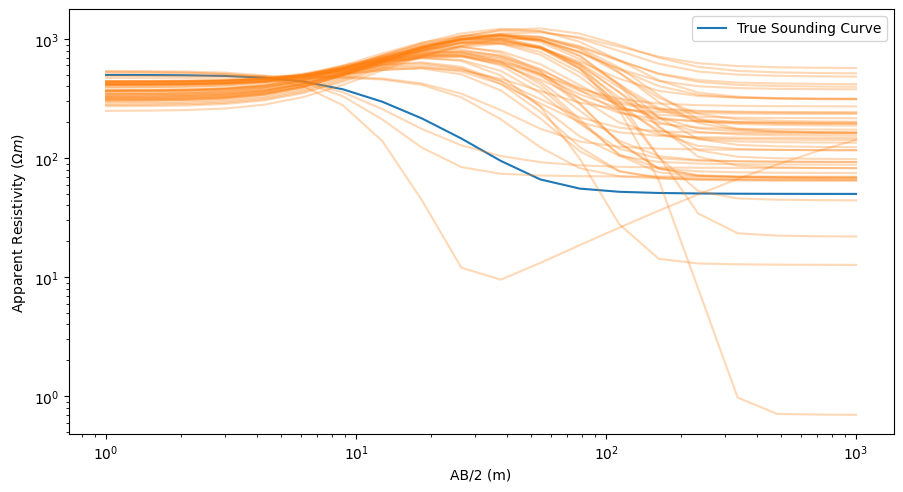

In [11]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook, label="True Sounding Curve")

for i in range(50):
    posterior_sample = posterior_samples[i]
    app_res = dc_forward_model_for_sbi_fixed_resistivities(np.array(posterior_sample))
    ax1.loglog(textbook_electrode_spacing, app_res, color='#ff7f0e',  alpha=0.3)
  


ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()


In [ ]:
with open("pickle/sbi_models/theta_1000_simulations_20_measurements.pkl", "wb") as input:
    pickle.dump(theta, input)
    
with open("pickle/sbi_models/x_1000_simulations_20_measurements.pkl", "wb") as input:
    pickle.dump(x, input)
    
with open("pickle/sbi_models/posterior_1000_simulations_resistivities_only_20_measurements.pkl", "wb") as input:
    pickle.dump(posterior, input)

### 2. Standard SNPE approach with 100 measurements and 10000 simulations 

In [21]:
infer_model = False

if infer_model:
    num_measurements = 100
    textbook_survey_100, textbook_electrode_spacing_100 = schlumberger_survey(num_measurements, min_spacing, max_spacing)
    apparent_resistivities_textbook_100 = dc_forward_model(earth_resistivities, earth_layer_thicknesses, textbook_survey_100)
    
    
    num_dim = 3
    prior_min = torch.as_tensor([0, 0, 0 ])
    prior_max = torch.as_tensor([5000, 5000, 5000 ])
    
    # Define the prior and the simulator for sampling based on the wrapped forward model and the prior
    prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))
    simulator, prior = prepare_for_sbi(dc_forward_model_for_sbi_fixed_resistivities, prior)
    inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)
    theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000)
    
    inference = inference.append_simulations(theta, x)
    density_estimator = inference.train()
    
    posterior = inference.build_posterior(density_estimator)
    posterior_samples = posterior.sample((100000,), x=apparent_resistivities_textbook_100)
    

else:
    with open("pickle/sbi_models/theta_10000_simulations.pkl", "rb") as input:
       theta_100 =  pickle.load(input)
    

    with open("pickle/sbi_models/x_10000_simulations.pkl", "rb") as input:
        x_100 = pickle.load(input)
    

    with open("pickle/sbi_models/posterior_10000_simulations_resistivities_only.pkl", "rb") as input:
        posterior_100 =  pickle.load(input)
    

UnsupportedOperation: read

In [ ]:
posterior = sbi_wrapper(simulator, prior, 10000)

### 3. Adding Noise to the model to make it more robust 

In [ ]:
##

In [ ]:
inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)

inference = inference.append_simulations(theta, x)